In [1]:
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy
from collections import Counter
import seaborn as sns

In [2]:
def num2key(string): #gives the equivalent of the number in the key of C
    return (string.replace('10','A#')
            .replace('1','C#')
            .replace('3','D#')
            .replace('6','F#')
            .replace('8','G#')
            .replace('9','A')
            .replace('11','B')
            .replace('0','C')
            .replace('2','D')
            .replace( '4','E')
            .replace('5','F')
            .replace('7','G'))

In [3]:
# Loading the data from the pre-processing part
clean_data = np.load('../dataset/clean_data.npy')
removed_duplicates = np.load('../dataset/removed_duplicates.npy')

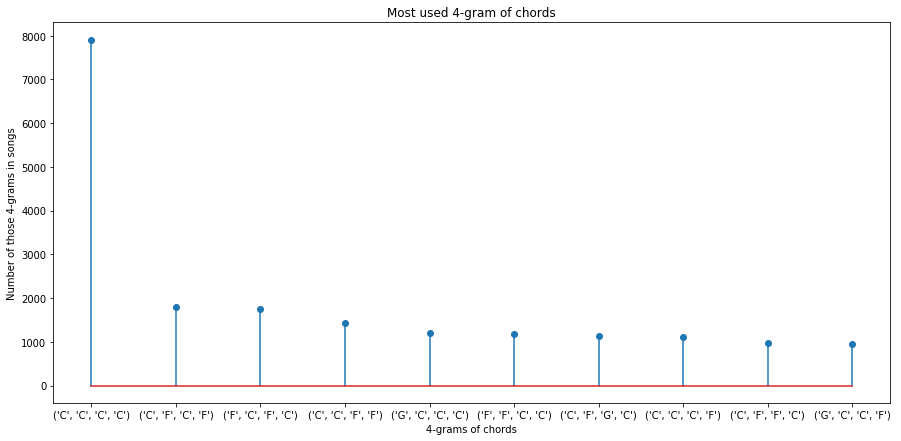

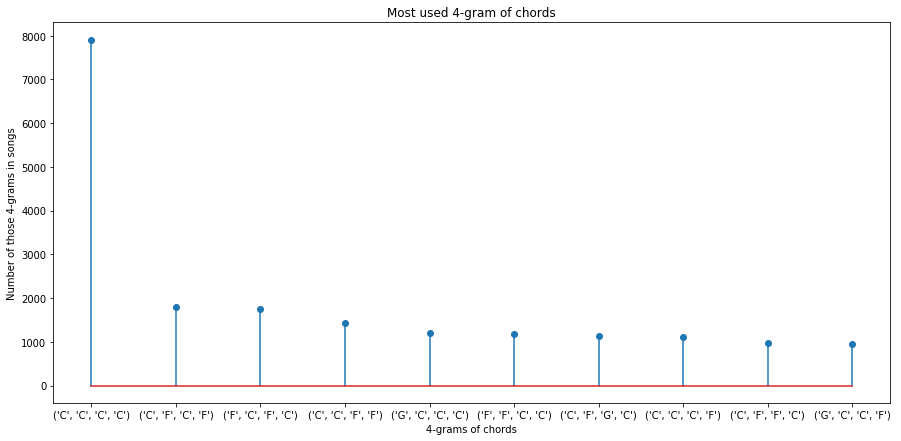

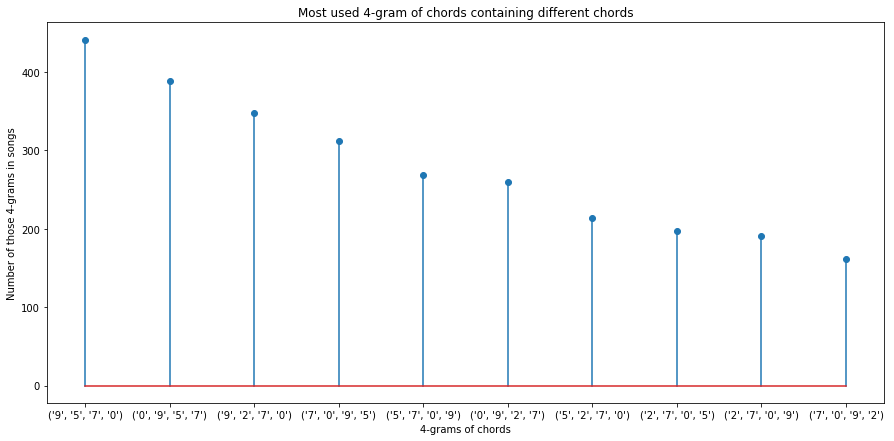

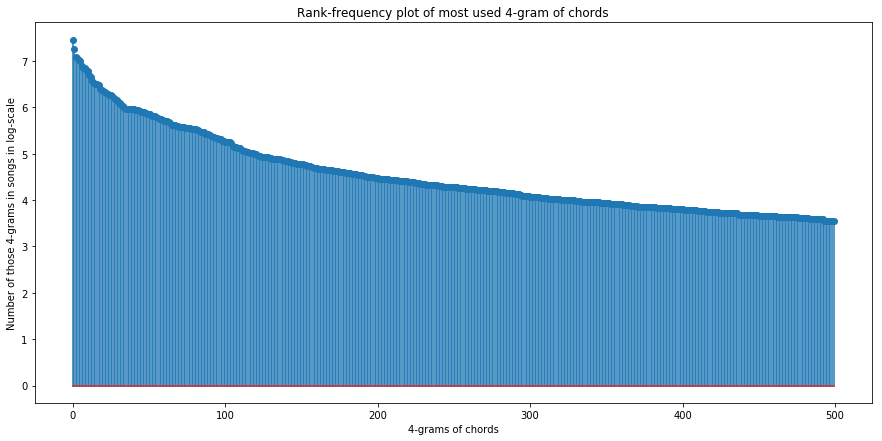

In [4]:
# General function for computing and plotting n-grams

def plot_n_grams(clean_data, ng,n, a=0 ):
    """
    This function computes and plots the n-grams of our clean data.
    clean_data is our input data
    ng is the number of chords we want in our sequences

    a is the first point you would like to plot
    """
    copyclean=copy.deepcopy(clean_data)
    for elem in copyclean:
        for e in elem[5]:
            e[0]=num2key(e[0])

    ngrams = []
    
    for k in range(890):
        for m in range(copyclean[k][5].shape[0] - ng + 1):
            ngrams.append(tuple([copyclean[k][5][m+o][0] for o in range(ng)]))    
            
    really_plot_ngrams(ngrams,n,ng)

def really_plot_ngrams(ngrams, n,ng,a=0):
    #n is the number of n-grams we want to plot
    
    
    c_gram = Counter(ngrams)
    mc_grams = [c_gram.most_common(n+a)[k][0] for k in range(a,a+n)]
    mc_grams_counts = [c_gram.most_common(n+a)[k][1] for k in range(a,a+n)]
    
    plt.figure(1, figsize=(15,7))

    plt.stem(np.arange(n),mc_grams_counts)
    plt.xticks(np.arange(n), mc_grams)
    plt.xlabel('{}-grams of chords'.format(ng))
    plt.ylabel('Number of those {}-grams in songs'.format(ng))
    plt.title('Most used {}-gram of chords'.format(ng))
    plt.show()
    
# General function for computing and plotting n-grams

def plot_n_grams_many(clean_data, ng, n, a=0 ):#cleaner plot for general shape
    """
    This function computes and plots the n-grams of our clean data.
    clean_data is our input data
    ng is the number of chords we want in our sequences
    n is the number of n-grams we want to plot
    a is the first point you would like to plot
    """

    ngrams = []
    copyclean=copy.deepcopy(clean_data)

    
    for k in range(890):
        for m in range(copyclean[k][5].shape[0] - ng + 1):
            ngrams.append(tuple([copyclean[k][5][m+o][0] for o in range(ng)]))          

    c_gram = Counter(ngrams)
    mc_grams = [c_gram.most_common(n+a)[k][0] for k in range(a,a+n)]
    mc_grams_counts = [c_gram.most_common(n+a)[k][1] for k in range(a,a+n)]
    log_mc_grams_counts = np.log(mc_grams_counts)
    
    plt.figure(1, figsize=(15,7))

    plt.stem(np.arange(n),log_mc_grams_counts)

    plt.xlabel('{}-grams of chords'.format(ng))
    plt.ylabel('Number of those {}-grams in songs in log-scale'.format(ng))
    plt.title('Rank-frequency plot of most used {}-gram of chords'.format(ng))
    plt.show()
    
    return ngrams

def plot_n_grams_diff(clean_data, ng, n, a=0 ):#cleaner plot for general shape
    """
    This function computes and plots the n-grams of our clean data.
    clean_data is our input data
    ng is the number of chords we want in our sequences
    n is the number of n-grams we want to plot
    a is the first point you would like to plot
    """

    ngrams = []
    copyclean=copy.deepcopy(clean_data)

    
    for k in range(890):
        for m in range(copyclean[k][5].shape[0] - ng + 1):
            truc=tuple([copyclean[k][5][m+o][0] for o in range(ng)])
            if len(truc)==len(set(truc)): #checks that every chord is different in the ngram
                ngrams.append(truc)

    c_gram = Counter(ngrams)
    mc_grams = [c_gram.most_common(n+a)[k][0] for k in range(a,a+n)]
    mc_grams_counts = [c_gram.most_common(n+a)[k][1] for k in range(a,a+n)]
    
    plt.figure(1, figsize=(15,7))

    plt.stem(np.arange(n),mc_grams_counts)
    plt.xticks(np.arange(n), mc_grams)
    plt.xlabel('{}-grams of chords'.format(ng))
    plt.ylabel('Number of those {}-grams in songs'.format(ng))
    plt.title('Most used {}-gram of chords containing different chords'.format(ng))
    plt.show()
    
    return ngrams

ngrams = plot_n_grams(clean_data,4,10)
ngrams = plot_n_grams(clean_data, 4, 10,18)
ngrams = plot_n_grams_diff(clean_data, 4, 10)
ngrams= plot_n_grams_many(clean_data,4,500,2)

What do we observe? It is ALMOST LINEAR

Pour moi non c'est pas linéaire. Après ça nous arrangerait bien que ce soit linéaire, parce que ça nous donnerait une loi de type power-law comme modèle d'évolution. Mais bon, on peut pas mentir en forçant le modèle.
moi je trouve que c'est pas si loin que ca d'etre linéaire

**Removing Cycles in the n-grams**

In [5]:
# This function checks if the two patterns are indeed the same to a cycle rotation
def same_pattern(patA, patB):
    cycle_list = [patA[x:] + patA[:x] for x in range(len(patA))]
    
    for ele in cycle_list:
        if (ele == patB):
            return True
    return False

In [6]:
same_pattern(('0', '4', '5', '3'), ('4', '5', '3', '0'))

True

In [7]:
# Let's define the pattern ngrams with taking into account possible cycles in the patterns
def remove_cycles(clean_data):
    
    ngrams = []
    copyclean = copy.deepcopy(clean_data)

    ng = 4

    # Normal n-grams creation
    for k in range(890):
        for m in range(copyclean[k][5].shape[0] - ng + 1):
            ngrams.append(tuple([copyclean[k][5][m+o][0] for o in range(ng)]))     

    c_gram = Counter(ngrams)
    mc_grams = c_gram.most_common()

    # We now group the patterns that are the same to a cycle rotation près
    h = 0

    # We use while loops, as for loops are less flexible in terms of conditions
    while(h < len(mc_grams)):
        d = 0
        hlim = h
        while(d < hlim):
            if h != d and h < len(mc_grams):
                if same_pattern(mc_grams[h][0], mc_grams[d][0]):
                    mc_grams[d] = (mc_grams[d][0], (mc_grams[h][1] + mc_grams[d][1]))
                    mc_grams.pop(h)
                    d -= 1
                    hlim -= 1
            d += 1
        h += 1
        
    mc_grams = sorted(mc_grams, key = lambda x: x[1], reverse = True)
    
    # What we return is the mc_grams object with all patterns that are the same grouped together
    return mc_grams

mc_grams_data = remove_cycles(removed_duplicates)

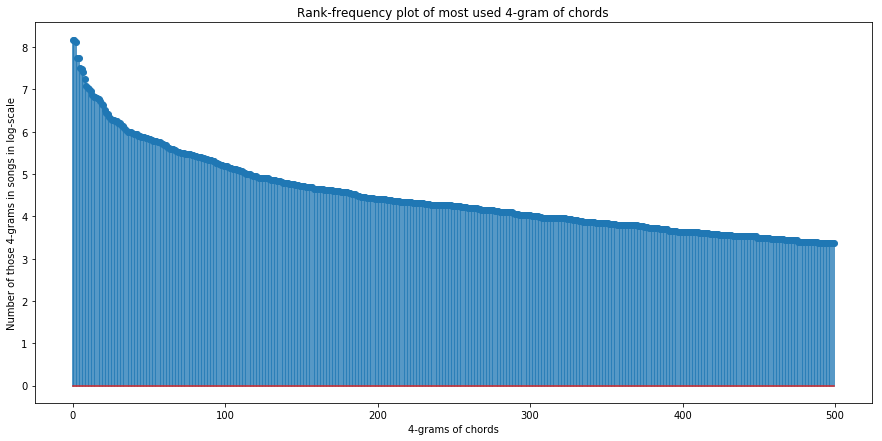

In [8]:
def plot_n_grams_many_without_cycles(clean_data, ng, n, a=0 ):#cleaner plot for general shape
    """
    This function computes and plots the n-grams of our clean data.
    clean_data is our input data
    ng is the number of chords we want in our sequences
    n is the number of n-grams we want to plot
    a is the first point you would like to plot
    """

    ngrams = []
    copyclean=copy.deepcopy(clean_data)

    c_gram = remove_cycles(copyclean)

    mc_grams = [c_gram[k][0] for k in range(a,a+n)]
    mc_grams_counts = [c_gram[k][1] for k in range(a,a+n)]
    log_mc_grams_counts = np.log(mc_grams_counts)
    
    plt.figure(1, figsize=(15,7))

    plt.stem(np.arange(n),log_mc_grams_counts)

    plt.xlabel('{}-grams of chords'.format(ng))
    plt.ylabel('Number of those {}-grams in songs in log-scale'.format(ng))
    plt.title('Rank-frequency plot of most used {}-gram of chords'.format(ng))
    plt.show()
    
    return ngrams

ngrams= plot_n_grams_many_without_cycles(clean_data,4,500,2)

In [9]:
diff_bigrams = [int(clean_data[k][5][m+1][0]) - int(clean_data[k][5][m][0]) for k in range(890) for m in range(clean_data[k][5].shape[0] - 1) ]

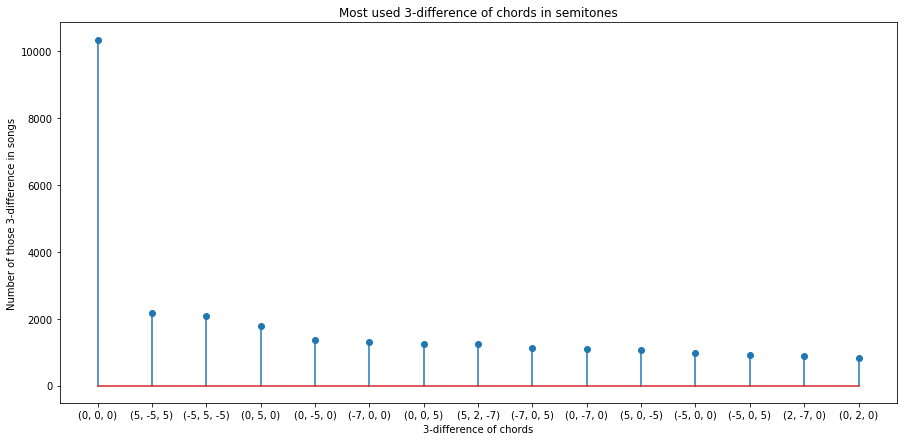

In [10]:
# General function for computing and plotting n-differences

def plot_diff_grams(clean_data, ng, n):
    """
    This function computes and plots the diff-grams of our clean data.
    clean_data is our input data
    ng is the number of chords we want in our sequences
    n is the number of n-grams we want to plot
    """
    
    diffgrams = []
    
    for k in range(890):
        for m in range(clean_data[k][5].shape[0] - ng+1):
            diffgrams.append(tuple([int(clean_data[k][5][m+o+1][0]) - int(clean_data[k][5][m+o][0]) for o in range(ng-1)]))          

    c_gram = Counter(diffgrams)

    mc_dgrams = [c_gram.most_common(n)[k][0] for k in range(n)]
    mc_dgrams_counts = [c_gram.most_common(n)[k][1] for k in range(n)]
    
    plt.figure(1, figsize=(15,7))

    plt.stem(np.arange(n),mc_dgrams_counts)
    plt.xticks(np.arange(n), mc_dgrams)
    plt.xlabel('{}-difference of chords'.format(ng-1))
    plt.ylabel('Number of those {}-difference in songs'.format(ng-1))
    plt.title('Most used {}-difference of chords in semitones'.format(ng-1))
    plt.show()
    
    
plot_diff_grams(clean_data, 4, 15)

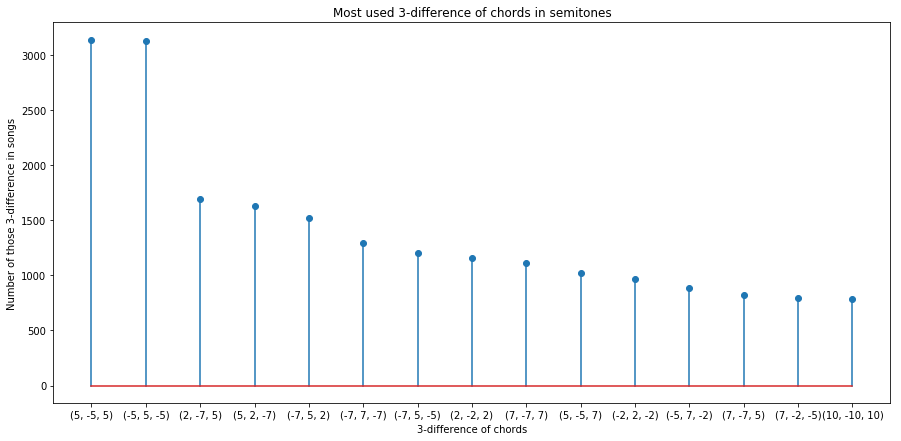

In [11]:
plot_diff_grams(removed_duplicates, 4, 15)

Let us precise that the term diff-gram was invented by us as it is a derivation from the term n-gram but for the case of interval differences between two subsequent chords.
Instead of considering the n-grams being the sequence of chords, we consider here the intervals between chords as our elements of the sequence, hence the name "diff-gram".

## Heatmaps

In [12]:
# General function for computing and plotting n-differences in heatmap hashion

def plot_heatmap(clean_data):
    """
    This function computes and plots the diff-grams of our clean data onto a heatmap.
    clean_data is our input data
    We take ng = 3 here, as we want to plot sequences of two consecutive intervals
    n is not defined here, as we want to plot all the n-grams possible
    """
        
    ng = 3
    # This numpy array will store the data for the 
    heatmap_data = np.zeros((23, 23))

    for k in range(890):
        for m in range(clean_data[k][5].shape[0] - ng+1):
            current_gram = tuple([int(clean_data[k][5][m+o+1][0]) - int(clean_data[k][5][m+o][0]) for o in range(ng-1)])         
            index_first = current_gram[0] + 11
            index_second = current_gram[1] + 11

            heatmap_data[index_second, index_first] += 1
    
    plt.figure(1, figsize=(19, 8))
    
    plt.subplot(121) # Left plot
    sns.heatmap(heatmap_data, cmap="coolwarm")
    plt.xticks(np.arange(23), np.arange(-11, 12))
    plt.yticks(np.arange(23), np.arange(-11, 12))
    plt.xlabel('Second Interval')
    plt.ylabel('First Interval')
    plt.title('Heatmap for trigrams')
    
    plt.subplot(122) # Right plot (logarithmic)
    sns.heatmap(np.maximum(np.log(heatmap_data), 0), cmap="coolwarm")
    plt.xticks(np.arange(23), np.arange(-11, 12))
    plt.yticks(np.arange(23), np.arange(-11, 12))
    plt.xlabel('Second Interval')
    plt.ylabel('First Interval')
    plt.title('Logarithmic heatmap for trigrams')
    
    plt.show()

/Users/Darcane/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


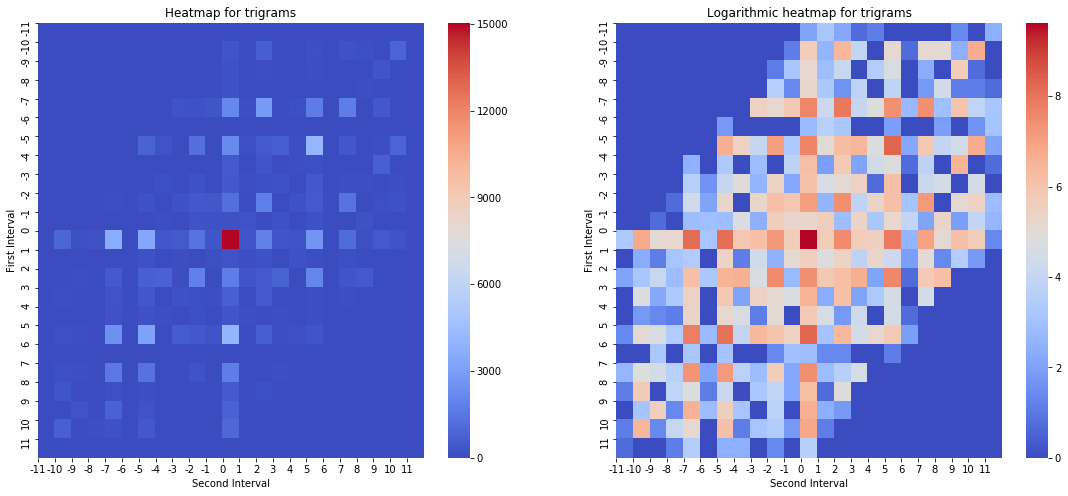

In [13]:
plot_heatmap(clean_data)

/Users/Darcane/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


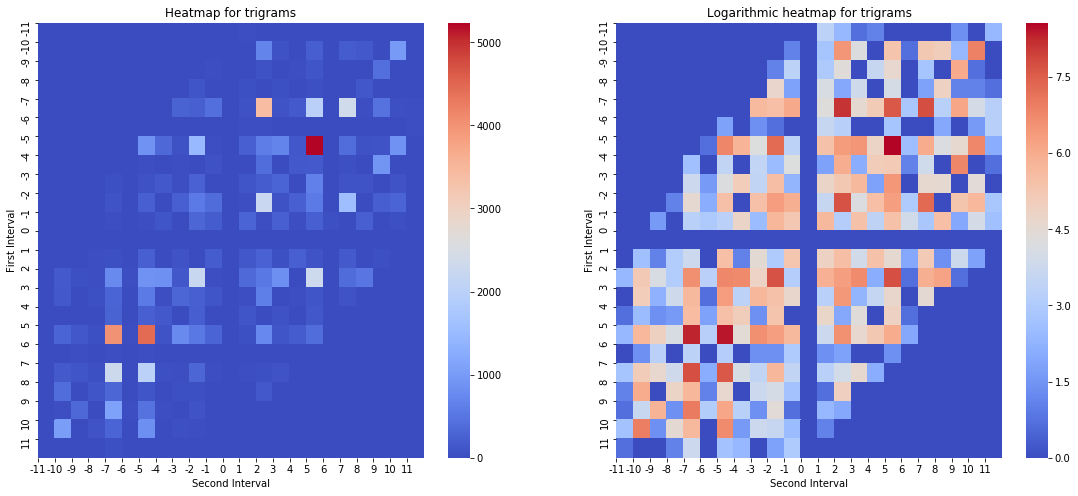

In [14]:
plot_heatmap(removed_duplicates)

Here we removed the duplicates, resulting in a heatmap with 0 on the row 0 and column 0.

## General function for computing and plotting n-grams with chord information

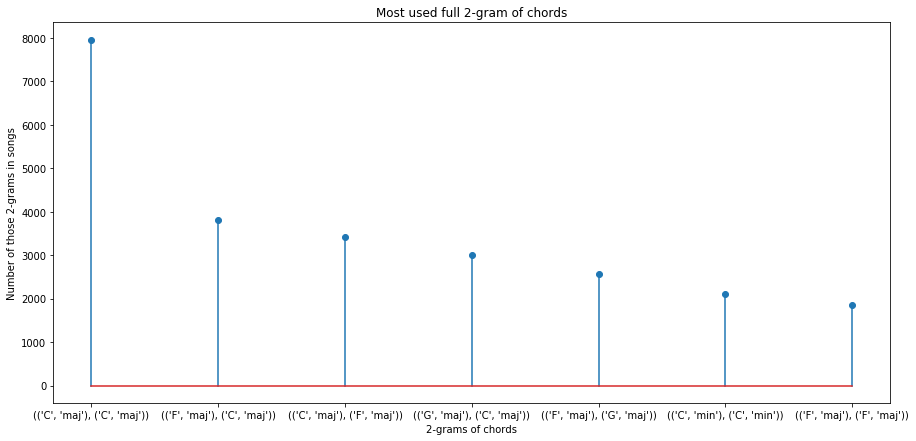

In [15]:
def plot_full_n_grams(clean_data, ng, n):
    
    """
    This function computes and plots the n-grams of our clean data with chord modes.
    clean_data is our input data
    ng is the number of chords we want in our sequences
    n is the number of n-grams we want to plot
    """
    copyclean=copy.deepcopy(clean_data)
    for elem in copyclean:
        for e in elem[5]:
            e[0]=num2key(e[0])
        
    ngrams = []

    for k in range(890):
        for m in range(copyclean[k][5].shape[0] - ng + 1):
            ngrams.append(tuple([((copyclean[k][5][m+o][0]), copyclean[k][5][m+o][1]) for o in range(ng)]))          

    c_gram = Counter(ngrams)
    
    mc_grams = [c_gram.most_common(n)[k][0] for k in range(n)]
    # for k in range(n):
      #   mc_grams.append(tuple([str(c_gram.most_common(n)[k][m][0][0])+', '+c_gram.most_common(n)[k][m][0][1] for m in range(ng)]))
    
    mc_grams_counts = [c_gram.most_common(n)[k][1] for k in range(n)]
    
    plt.figure(1, figsize=(15,7))

    plt.stem(np.arange(n),mc_grams_counts)
    plt.xticks(np.arange(n), mc_grams)
    plt.xlabel('{}-grams of chords'.format(ng))
    plt.ylabel('Number of those {}-grams in songs'.format(ng))
    plt.title('Most used full {}-gram of chords'.format(ng))
    plt.show()
    
    
plot_full_n_grams(clean_data, 2, 7)

# Evolution of popularity of 4-grams containing A, G, C and F over time

In [16]:
from datetime import datetime
year24grams = dict()
# For bigrams, ng = 2
ng=4

for elem in clean_data: # populate empty (to have existing keys)
    year = datetime.strptime(elem[1], '%m/%d/%Y').year
    year24grams[year]=list()
    
for elem in clean_data: # populate for real
    year = datetime.strptime(elem[1], '%m/%d/%Y').year
    
    for m in range(elem[5].shape[0] - ng + 1):
        year24grams[year].append(tuple([int(elem[5][m+o][0]) for o in range(ng)]))

In [17]:
year2chord05 = dict()

#change everything to sets
check={0,5,7,9}
for year in year24grams:
    c=0
    for elem in year24grams[year]:
        otruc=set(elem)
        if otruc==check:
            c+=1
    year2chord05[year] = c / len(year24grams[year])
    
# year2chord05[year]

In [18]:
def moving_average(X):
    N = 10
    augmented_X = tuple([X[0] for i in range(5)]) + X + tuple([X[-1] for i in range(4)])
    res = np.convolve(augmented_X, np.ones((N,))/N, mode='valid')
    return res

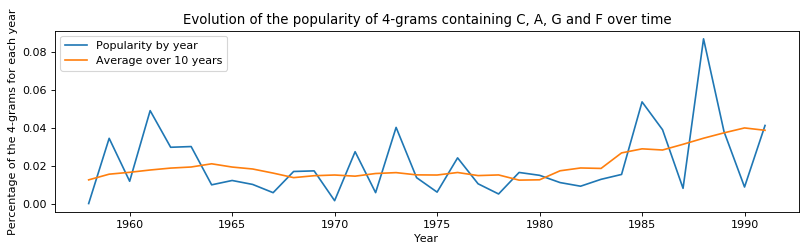

In [19]:
lists = sorted(year2chord05.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.figure(num=None, figsize=(12, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x, y, label="Popularity by year")
plt.plot(x, moving_average(y), label="Average over 10 years")

plt.legend()
plt.xlabel('Year')
plt.ylabel('Percentage of the 4-grams for each year')
plt.title('Evolution of the popularity of 4-grams containing C, A, G and F over time')
plt.show()

# Evolution of popularity of 4-grams containing C and A# over time

In [20]:
from datetime import datetime
year24grams = dict()
# For bigrams, ng = 2
ng=2

for elem in clean_data: # populate empty (to have existing keys)
    year = datetime.strptime(elem[1], '%m/%d/%Y').year
    year24grams[year]=list()
    
for elem in clean_data: # populate for real
    year = datetime.strptime(elem[1], '%m/%d/%Y').year
    
    for m in range(elem[5].shape[0] - ng + 1):
        year24grams[year].append(tuple([int(elem[5][m+o][0]) for o in range(ng)]))

In [21]:
year2chord05 = dict()

#change everything to sets
check={0,10}
for year in year24grams:
    c=0
    for elem in year24grams[year]:
        otruc=set(elem)
        if otruc==check:
            c+=1
    year2chord05[year] = c / len(year24grams[year])
    
# year2chord05[year]

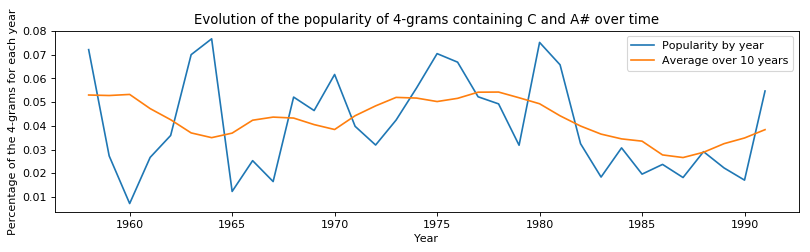

In [22]:
lists = sorted(year2chord05.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.figure(num=None, figsize=(12, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x, y, label="Popularity by year")
plt.plot(x, moving_average(y), label="Average over 10 years")

plt.legend()
plt.xlabel('Year')
plt.ylabel('Percentage of the 4-grams for each year')
plt.title('Evolution of the popularity of 4-grams containing C and A# over time')
plt.show()

# Evolution of popularity of (C,F) bigram over time

In [23]:
from datetime import datetime
year2bigrams = dict()
# For bigrams, ng = 2
ng=2

for elem in clean_data: # populate empty (to have existing keys)
    year = datetime.strptime(elem[1], '%m/%d/%Y').year
    year2fourgrams[year]=list()
    
for elem in clean_data: # populate for real
    year = datetime.strptime(elem[1], '%m/%d/%Y').year
    
    for m in range(elem[5].shape[0] - ng + 1):
        year2fourgrams[year].append(tuple([int(elem[5][m+o][0]) for o in range(ng)]))

NameError: name 'year2fourgrams' is not defined

In [ ]:
year2chord05 = dict()

for year in year2bigrams:
    year2chord05[year] = year2bigrams[year].count(tuple((0,5))) / len(year2bigrams[year])
    
# year2chord05[year]

In [ ]:
year2chord05 = dict()

plt.figure(num=None, figsize=(12, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x, y, label="Popularity by year")
plt.plot(x, moving_average(y), label="Average over 10 years")

plt.legend()
plt.xlabel('Year')
plt.ylabel('Percentage of the bigram (0,5) for each year')
plt.title('Evolution of the popularity of the (0,5) bigram over time')
plt.show()

This pattern corresponds to the transition from the Root to the Fourth : this is either an ascending fourth transition or a descending fifth.

# Evolution of popularity of (G, C) bigram over time

In [ ]:
from datetime import datetime
year2bigrams = dict()
# For bigrams, ng = 2
ng=2

for elem in clean_data: # populate empty (to have existing keys)
    year = datetime.strptime(elem[1], '%m/%d/%Y').year
    year2bigrams[year]=list()
    
year2chord05[year]

In [ ]:
year2chord70 = dict()

for year in year2bigrams:
    year2chord70[year] = year2bigrams[year].count(tuple((7,0))) / len(year2bigrams[year])
    
# year2chord70[year]

In [ ]:
lists = sorted(year2chord70.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.figure(num=None, figsize=(12, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(x, y, label="Popularity by year")
plt.plot(x, moving_average(y), label="Average over 10 years")

plt.legend()
plt.xlabel('Year')
plt.ylabel('Percentage of the bigram (G,C) for each year')
plt.title('Evolution of the popularity of the (G,C) bigram over time')
plt.show()

This pattern corresponds to the transition from the Fifth to the Root : this is either a descending fifth transition or an ascending fourth.

# Evolution of the popularity of descending fifths transitions

Note that descending fifths can also correspond to ascending fourths transitions.

In [ ]:
plot_diff_grams(clean_data, 2, 15)

Let us evaluate the popularity of the bigram transition (-7), that is descending fifth or ascending fourth.

In [ ]:
from datetime import datetime
year2diff = dict()
# For 1-difference, ng = 2
ng=2

for elem in clean_data: # populate empty (to have existing keys)
    year = datetime.strptime(elem[1], '%m/%d/%Y').year
    year2diff[year]=list()
    
for elem in clean_data: # populate for real
    year = datetime.strptime(elem[1], '%m/%d/%Y').year
    
    for m in range(elem[5].shape[0] - ng + 1):
        year2diff[year].append(int(elem[5][m+1][0]) - int(elem[5][m][0]))

In [ ]:
year2diff_7 = dict()

for year in year2bigrams:
    year2diff_7[year] = year2diff[year].count(-7) / len(year2diff[year])

In [ ]:
lists = sorted(year2diff_7.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

We see that the curve is quite similar to the one for the (7,0) bigram. However, this curve encompasses more patterns than the (7,0) bigram only : it takes into account all the bigrams of the form (k+7,k) including (7,0).

Globally, the tendency is that the usage of this transition slightly diminishes over time.

# Most popular chords coming from and leading to the Root

In [ ]:
bigrams = [(int(clean_data[k][5][m][0]), int(clean_data[k][5][m+1][0])) for k in range(890) for m in range(clean_data[k][5].shape[0] - 1) ]

In [ ]:
def chords_leading_root(big, n):
    
    bigrams_to_root = []
    for k in range(len(big)):
        if bigrams[k][1] == 0:
            bigrams_to_root.append(bigrams[k][0])
            
    c_bi_r = Counter(bigrams_to_root)

    mc_bigrams = [c_bi_r.most_common(n)[k][0] for k in range(n)]
    mc_bigrams_counts = [c_bi_r.most_common(n)[k][1] for k in range(n)]
    
    plt.figure(1, figsize=(15,7))

    plt.stem(np.arange(n),mc_bigrams_counts)
    plt.xticks(np.arange(n), mc_bigrams)
    plt.xlabel('Chord leading to the root')
    plt.ylabel('Number of those chords in songs')
    plt.title('Most used chords leading to the root')
    plt.show()

In [ ]:
chords_leading_root(bigrams, 12)

Logically, we see that the most frequent chords that lead to a root chord are root chords, fourths and fifths.

After that, we have the minor seventh and the second.

In [ ]:
bigrams_from_root = []
for k in range(len(bigrams)):
    if bigrams[k][0] == 0:
        bigrams_from_root.append(bigrams[k][1])

In [ ]:
def chords_from_root(big, n):
    
    bigrams_from_root = []
    for k in range(len(big)):
        if bigrams[k][0] == 0:
            bigrams_from_root.append(bigrams[k][1])
            
    c_bi_f = Counter(bigrams_from_root)

    mc_bigrams = [c_bi_f.most_common(n)[k][0] for k in range(n)]
    mc_bigrams_counts = [c_bi_f.most_common(n)[k][1] for k in range(n)]
    
    plt.figure(1, figsize=(15,7))

    plt.stem(np.arange(n),mc_bigrams_counts)
    plt.xticks(np.arange(n), mc_bigrams)
    plt.xlabel('Chord coming from the root')
    plt.ylabel('Number of those chords in songs')
    plt.title('Most used chords coming from the root')
    plt.show()

In [ ]:
chords_from_root(bigrams, 12)

Same as before : we see the same repartition of chords that come from the root than for the ones leading to the root. 

# Popularity of modes over years

In [ ]:
# Modes with their chords : https://en.wikipedia.org/wiki/Roman_numeral_analysis
ionian = np.array(( np.array(('0', "maj")), np.array(('0', "maj7")), np.array(('2', "min")), np.array(('2', "7")),np.array(('4', "min")), np.array(('4', "7")), np.array(('5', "maj")), np.array(('5', "maj7")), np.array(('7', "maj")), np.array(('7', "7")), np.array(('9', "min")), np.array(('9', "7")), np.array(('11', "min")), np.array(('11', "dim")), np.array(('11', "7"))))
dorian = np.array(( np.array(('0', "min")), np.array(('0', "7")), np.array(('2', "min")), np.array(('2', "7")),np.array(('3', "maj")), np.array(('3', "maj7")), np.array(('5', "maj")), np.array(('5', "7")), np.array(('7', "min")), np.array(('7', "7")), np.array(('9', "min")), np.array(('9', "7")), np.array(('10', "maj7")), np.array(('10', "maj"))))
phrygian = np.array(( np.array(('0', "min")), np.array(('0', "7")), np.array(('1', "maj")), np.array(('1', "maj7")),np.array(('3', "maj")), np.array(('3', "7")), np.array(('5', "min")), np.array(('5', "7")), np.array(('7', "min")), np.array(('7', "7")), np.array(('8', "maj")), np.array(('8', "maj7")), np.array(('10', "min")), np.array(('10', "7"))))
lydian = np.array(( np.array(('0', "maj")), np.array(('0', "maj7")), np.array(('2', "maj")), np.array(('2', "maj7")),np.array(('4', "min")), np.array(('4', "7")), np.array(('6', "min")), np.array(('6', "7")), np.array(('7', "maj")), np.array(('7', "maj7")), np.array(('9', "min")), np.array(('9', "7")), np.array(('11', "min")), np.array(('11', "7"))))
mixolydian = np.array(( np.array(('0', "maj")), np.array(('0', "7")), np.array(('2', "min")), np.array(('2', "7")),np.array(('4', "min")),np.array(('4', "dim")), np.array(('4', "7")), np.array(('5', "maj")), np.array(('5', "maj7")), np.array(('7', "min")), np.array(('7', "7")), np.array(('9', "min")), np.array(('9', "7")), np.array(('10', "maj")), np.array(('10', "maj7"))))
aeolian = np.array(( np.array(('0', "min")), np.array(('0', "7")), np.array(('2', "min")), np.array(('2', "7")), np.array(('2', "dim")), np.array(('3', "maj")), np.array(('3', "maj7")), np.array(('5', "min")), np.array(('5', "7")), np.array(('7', "min")), np.array(('7', "7")), np.array(('8', "maj")), np.array(('8', "maj7")), np.array(('10', "maj")), np.array(('10', "maj7"))))
locrian = np.array(( np.array(('0', "min")), np.array(('0', "dim")), np.array(('0', "7")), np.array(('1', "maj")), np.array(('1', "maj7")),np.array(('3', "min")), np.array(('3', "7")), np.array(('5', "min")), np.array(('5', "7")), np.array(('6', "maj")), np.array(('6', "maj7")), np.array(('8', "maj")), np.array(('8', "maj7")), np.array(('10', "min")), np.array(('10', "7"))))

allmode=np.concatenate((ionian,dorian,phrygian,lydian,mixolydian,aeolian,locrian),axis=0)

# Data structure conversion
ionian = list(map(tuple, ionian))
dorian = list(map(tuple, dorian))
phrygian = list(map(tuple, phrygian))
lydian = list(map(tuple, lydian))
mixolydian = list(map(tuple, mixolydian))
aeolian = list(map(tuple, aeolian))
locrian = list(map(tuple, locrian))

In [ ]:
def song_mode(chords, mode):
    '''
    Function to compute proportion of chords in a song, that belong to the given mode.
    '''
    match_chords = 0
    for chord in chords:
        if(chord in mode):
            match_chords += 1

    return match_chords/len(chords)

def year2mode(clean_data, mode):
    '''
    Function to compute the average % utilisation of a mode over the years
    '''
    from datetime import datetime
    year2ionian = dict()

    for elem in clean_data: # populate empty (to have existing keys)
        year = datetime.strptime(elem[1], '%m/%d/%Y').year
        year2ionian[year]=list()

    for elem in clean_data: # populate for real
        year = datetime.strptime(elem[1], '%m/%d/%Y').year
        year2ionian[year].append(song_mode(list(map(tuple, elem[5])), mode))

    for year in year2ionian: # computing the means for each year
        year2ionian[year] = np.mean(year2ionian[year])
        
    return year2ionian

In [ ]:
# Dictionaries of year to mode proportions
year2ionian = year2mode(clean_data, ionian)
year2dorian = year2mode(clean_data, dorian)
year2phrygian = year2mode(clean_data, phrygian)
year2lydian = year2mode(clean_data, lydian)
year2mixolydian = year2mode(clean_data, mixolydian)
year2aeolian = year2mode(clean_data, aeolian)
year2locrian = year2mode(clean_data, locrian)

year2all=year2mode(clean_data, allmode)
    
# plotting
plt.figure(1, figsize=(15,7))

lists = sorted(year2ionian.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y, label='Ionian')

lists = sorted(year2dorian.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y, label='Dorian')

lists = sorted(year2phrygian.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y, label='Phrygian')

lists = sorted(year2lydian.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y, label='Lydian')

lists = sorted(year2mixolydian.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y, label='Mixolydian')

lists = sorted(year2aeolian.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y, label='Aeolian')

lists = sorted(year2locrian.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y, label='Locrian')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Percentage of songs using particular modes each year')
plt.title('Evolution of the usage of modes over time in pop music')
plt.show()

lists = sorted(year2all.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y)

plt.legend()
plt.xlabel('Year')
plt.ylabel('Percentage of songs using at least one of the diatonic modes')
plt.title('Evolution of the usage of all modes over time in pop music')
#plt.show()

# Are songs becoming less major, less minor (diatonically speaking, not caring about chords) ?

In [ ]:
major = list(('0', '2', '4', '5', '7', '9', '11'))
minor = list(('0', '2', '3', '5', '7', '9', '10'))
majorminor = list(('0', '2', '3', '4', '5', '7', '9', '10', '11'))

In [ ]:
def song_majmin(chords, mode):
    '''
    Function to compute proportion of chords not in given major/minor scheme
    '''
    match_chords = 0
    for chord in chords:
        if(chord[0] not in mode):
            match_chords += 1

    return match_chords/len(chords)

def year2majmin(clean_data, mode):
    '''
    Function to compute the average % utilisation of a maj/min over the years
    '''
    from datetime import datetime
    year2ionian = dict()

    for elem in clean_data: # populate empty (to have existing keys)
        year = datetime.strptime(elem[1], '%m/%d/%Y').year
        year2ionian[year]=list()

    for elem in clean_data: # populate for real
        year = datetime.strptime(elem[1], '%m/%d/%Y').year
        year2ionian[year].append(song_majmin(list(map(tuple, elem[5])), mode))

    for year in year2ionian: # computing the means for each year
        year2ionian[year] = np.mean(year2ionian[year])
        
    return year2ionian

In [ ]:
# Dictionaries of year to mode proportions
year2notmajor = year2majmin(clean_data, major)
year2notminor = year2majmin(clean_data, minor)
year2notmajorminor = year2majmin(clean_data, majorminor)

# plotting
plt.figure(1, figsize=(15,7))

lists = sorted(year2notmajor.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, moving_average(y), label='Songs not in major')

lists = sorted(year2notminor.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, moving_average(y), label='Songs not in minor')

lists = sorted(year2notmajorminor.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, moving_average(y), label='Songs neither in major nor minor')


plt.legend()
plt.xlabel('Year')
plt.ylabel('Percentage of songs using particular modes each year')
plt.title('Evolution of the usage of modes over time in pop music')
plt.show()

less major YES, but less minor bof bof

# Pattern Extractor

In [ ]:
"""
Verse and chorus chord pattern extraction:

we compute all ngrams possible in verses and chorus, then among ngrams which are the most common, we save the ones with the highest n.
chorus chords become chorus ngrams

we check at the time we select the ngrams, if they have anything in common with the current ngrams :
this way we delete each them one by one

"""

patterns =[]
patternsfailed=[]
both = []# all passed patterns
for elem in clean_data :

    for i in range(2,elem[6].shape[0]) :
    
        for m in range(elem[6].shape[0] - i + 1): 
            
            ngram= tuple([(int(elem[6][m+o][0]), elem[6][m+o][1]) for o in range(i)])  
            
            if ngram in (both) :
                patterns.append(ngram)

        both.append(ngram) #here the ngram is added to the patterns that we compare with.
        #this means that if the ngram happens again in the same song, it is not taken into account

    #same for verses:
    for i in range(2,elem[7].shape[0]):
        for m in range(elem[7].shape[0] - i + 1):
            ngram= tuple([(int(elem[7][m+o][0]), elem[7][m+o][1]) for o in range(i)])  
            
            if ngram in (both) :
                patterns.append(ngram)

        both.append(ngram)

print(len(patterns))

In [ ]:
np.save('../dataset/allpatterns.npy', patterns) #the code is quite long to run, therefore it is easier to save it and reuse it.


## Subpattern Removal: 
## We remove the patterns fully contained in other patterns

In [ ]:
def patternbelongs(patbig,patsmall):
    if len(patbig) > len(patsmall):
        i=len(patsmall)
        ngrams=[]
        for m in range(len(patbig) - i + 1): #we first create all the ngrams of size same as small pattern frompatbig
            ngrams.append(tuple([(int(patbig[m+o][0]), patbig[m+o][1]) for o in range(i)]))
        return patsmall in ngrams
    else:
        return False


In [ ]:
#checking if patternbelongs works

patsmall=((0, 'maj'),(5, 'maj'))
patbigbad=((5, 'maj'),(0, 'maj'),(0, 'maj'))
patbiggood=((0, 'maj'),(0, 'maj'),(5, 'maj'))

print(patternbelongs(patbigbad,patsmall))
print(patternbelongs(patbiggood,patsmall))

In [ ]:
#removing subpatterns
print(len(patterns))

for patbig in patterns:
    for patsmall in patterns:
        if patternbelongs(patbig,patsmall):
            del patsmall
print(len(patterns))

In [ ]:
#plots to compare with our initial ngrams:

really_plot_ngrams(patterns,10,4)

In [ ]:
c_gram=Counter(fourgrampatterns)
print(c_gram.most_common(10))
mc_grams=[]
mc_grams =[c_gram.most_common(10)[k][0] for k in range(10)]
print(len(mc_grams))

In [ ]:
#the code will run separately as the computation is slow here

#WECANDO BETTER : we check at the time we select the ngrams, if they have anything in common with the current ngrams :
#this way we delete each one one by one